In [7]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
import time
import glob
import gc

import h5py
import hdf5plugin

import jax
import jax.numpy as jnp
from flax import nnx
from jax import grad, jit, vmap, random
import optax
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath(os.path.join('../')))
from geometric_bayesian.models import MLP
from geometric_bayesian.utils import DataLoader, get_sinusoid_example, plot_regression, ggn, array_to_pytree, pytree_to_array
from geometric_bayesian.densities import Normal
from geometric_bayesian.operators import psd_operator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
key = jax.random.key(0)
num_training_samples = 150
batch_size = 150
X_train, y_train, train_loader, X_test, y_test = get_sinusoid_example(
    num_data=num_training_samples, sigma_noise=0.3, batch_size=batch_size
)

In [11]:
model = MLP(
    layers=[1, 64, 1],
    rngs=nnx.Rngs(params=0),
    prob_out=False,
)

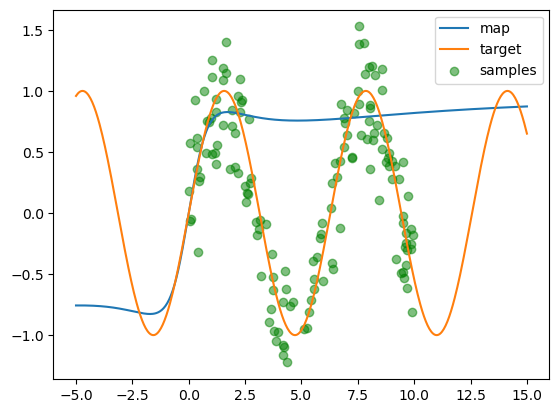

In [12]:
fig = plot_regression(model, X_test, y_test, X_train, y_train)

In [13]:
n_epochs = 1000
step_size = 1e-2

optimizer = nnx.Optimizer(model, optax.adam(step_size))

def criterion(x, y):
    return jnp.mean((x - y) ** 2)

@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(model: MLP):
        y_pred = model(x)
        return criterion(y, y_pred)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads) 

    return loss

In [14]:
losses = []
for epoch in range(n_epochs):
    for x_tr, y_tr in train_loader:
        losses.append(train_step(model, optimizer, x_tr, y_tr))

    if epoch % 100 == 0:
        print(f"[epoch {epoch}]: loss: {losses[-1]:.4f}")

print(f'{optimizer.step.value = }')
print(f"Final loss: {losses[-1]:.4f}")

[epoch 0]: loss: 0.7330
[epoch 100]: loss: 0.3122
[epoch 200]: loss: 0.2243
[epoch 300]: loss: 0.1841
[epoch 400]: loss: 0.1124
[epoch 500]: loss: 0.0864
[epoch 600]: loss: 0.0815
[epoch 700]: loss: 0.0802
[epoch 800]: loss: 0.0808
[epoch 900]: loss: 0.0796
optimizer.step.value = Array(1000, dtype=uint32)
Final loss: 0.0795


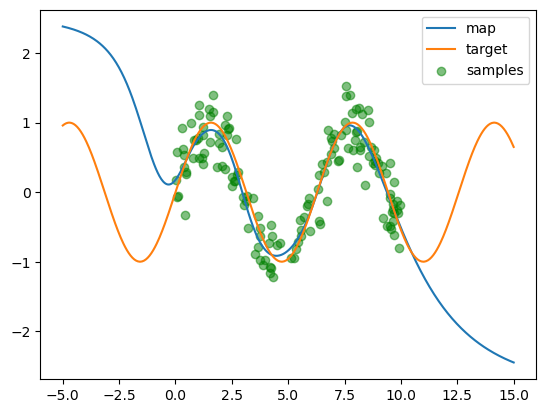

In [15]:
fig = plot_regression(model, X_test, y_test, X_train, y_train)

In [15]:
from geometric_bayesian.densities import MultivariateNormal
from geometric_bayesian.operators import DiagOperator
MultivariateNormal(model(X_train).squeeze(), DiagOperator(1.0, len(y_train)))._logpdf(y_train)

Array([[-85.54516 , -85.47586 , -85.57777 , ..., -86.36407 , -85.56462 ,
        -85.486145],
       [-85.66908 , -85.599785, -85.70169 , ..., -86.48799 , -85.688545,
        -85.61007 ],
       [-85.90328 , -85.833984, -85.93589 , ..., -86.72219 , -85.922745,
        -85.84427 ],
       ...,
       [-85.127716, -85.05842 , -85.160324, ..., -85.946625, -85.14718 ,
        -85.0687  ],
       [-85.81134 , -85.74204 , -85.84395 , ..., -86.63025 , -85.8308  ,
        -85.75233 ],
       [-85.95631 , -85.88701 , -85.988914, ..., -86.775215, -85.97577 ,
        -85.89729 ]], dtype=float32)

In [10]:
ggn_mv = ggn(
    model=model,
    train_data=(X_train, y_train),
    likelihood_density=Normal, 
    cov=jnp.array(1.0)
)

In [11]:
graph_def, map_params = nnx.split(model)
def model_fn(input, params):
    return nnx.call((graph_def, params))(input)[0]

In [10]:
num_params = sum(x.size for x in jax.tree.leaves(map_params))
eye_pytree = array_to_pytree(jnp.eye(num_params), map_params)
# precision = pytree_to_array(jax.lax.map(ggn_mv, eye_pytree, batch_size=None),axis=0)

In [24]:
from geometric_bayesian.types import Vector, Matrix

def pf_jvp(input: Vector | Matrix, vector: Vector) -> Vector | Matrix:
    return jax.jvp(
        lambda p: model_fn(input=input, params=p),
        (map_params,),
        (vector,),
    )[1]

def pf_vjp(input: Vector | Matrix, vector: Vector | Matrix) -> Vector | Matrix:
    out, vjp_fun = jax.vjp(
        lambda p: model_fn(input=input, params=p), map_params
    )
    return vjp_fun(vector)

In [25]:
grad_net = jax.lax.map(lambda p : pf_jvp(X_test[0], p), eye_pytree, batch_size=None).squeeze()

In [51]:
pf_jvp(X_test[0], ggn_mv(pf_vjp(X_test[0],jnp.array([1.0]))[0]))

Array([296944.75], dtype=float32)

In [31]:
tmp, _ = jax.tree.flatten(eye_pytree)

In [33]:
tmp[0].shape

(193, 64)

In [20]:
pf_jvp(X_test[0],eye_pytree)

ValueError: jvp called with different primal and tangent shapes;Got primal shape (64,) and tangent shape as (193, 64)